In [109]:
import geopandas as gpd

from features.income import Income
from features.violence_calls import ViolenceCalls
from features.households import Households
from features.population import Population
from features.feature_constructor import Feature
from detroit_geos import get_detroit_census_geos, get_detroit_boundaries

import patsy
from patsy import dmatrices, dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

# Fetch geometries for visualization

In [110]:
tracts = get_detroit_census_geos(decennial_census_year=2010,target_geo_grain='tract').set_index('geo_id')
detroit = get_detroit_boundaries()
block = get_detroit_census_geos(decennial_census_year=2010,target_geo_grain='block').set_index('geo_id')

# Build Features

In [111]:
target_geo_grain = 'tract'

population = Population(decennial_census_year=2010,population_data_path='population',verbose=False)
# feat_population = population.construct_features(target_geo_grain)
# population.cache_features()
feat_population = population.load_cached_features(target_geo_grain)

call = ViolenceCalls(decennial_census_year=2010,verbose=False)
feat_call = call.load_cached_features(target_geo_grain)

income = Income(verbose=False)
feat_income = income.load_cached_features(target_geo_grain=target_geo_grain)

households = Households()
feat_households = households.load_cached_features(target_geo_grain)

feat_tuple = (feat_income,feat_households,feat_population,feat_call)
feat_df = pd.concat((feat_income,feat_households,feat_population,feat_call),axis=1)

In [113]:
feat_df.head()

,per_capita_income,per_household_income,households,married_families,non_family_households,population,violence_calls
tract,,,,,,,
2.616350e+10,3369.0,49015.0,1438,249,674,4032,2257.0
2.616350e+10,2834.0,61980.0,1088,190,370,3207,2334.0
2.616350e+10,1900.0,50345.0,811,61,491,3137,1948.0
2.616350e+10,1052.0,34880.0,375,45,140,1664,1030.0
2.616350e+10,1289.0,43058.0,506,61,274,2205,1450.0


In [47]:
df = feat_df.loc[lambda x: x.population > 5].assign(
    total_income=lambda x: x.households * x.per_household_income,
    new_per_capita_income=lambda x: x.total_income / x.population,
    calls_per_capita = lambda x: x.violence_calls/x.population,
)

<AxesSubplot:>

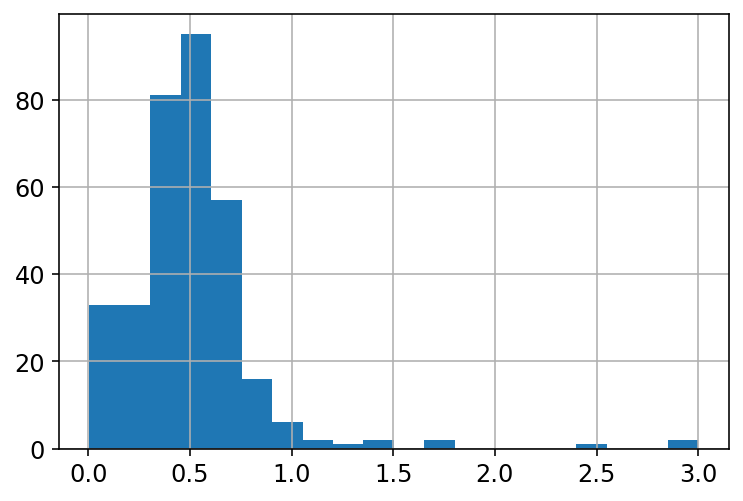

In [84]:
df.sort_values('calls_per_capita').calls_per_capita.clip(upper=3).hist(bins=20)

In [85]:
df.calls_per_capita.idxmax()

26163577000.0

In [88]:
tracts.head()

,geometry,longitude,latitude
geo_id,,,
2.616350e+10,"POLYGON ((-82.95578 42.43558, -82.95580 42.436...",-82.951065,42.444180
2.616350e+10,"POLYGON ((-82.97099 42.44526, -82.97078 42.445...",-82.963043,42.446190
2.616350e+10,"POLYGON ((-82.97690 42.43628, -82.97648 42.436...",-82.965183,42.439028
2.616350e+10,"POLYGON ((-82.98668 42.42144, -82.98621 42.422...",-82.979006,42.426164
2.616350e+10,"POLYGON ((-82.97490 42.42227, -82.97493 42.423...",-82.967849,42.424141


In [108]:
# (df.population/df.households).replace({np.inf:np.nan}).dropna()
df.assign(people_per_household=(df.population/df.households)).sort_values('people_per_household').loc[:,['population','households']].head(10)

,population,households
tract,,
2.616358e+10,16,1743
2.616358e+10,58,2049
2.616358e+10,53,1675
2.616355e+10,87,1254
2.616355e+10,63,840
2.616358e+10,156,1865
2.616355e+10,137,1494
2.616355e+10,159,1537
2.616357e+10,165,1338


<AxesSubplot:>

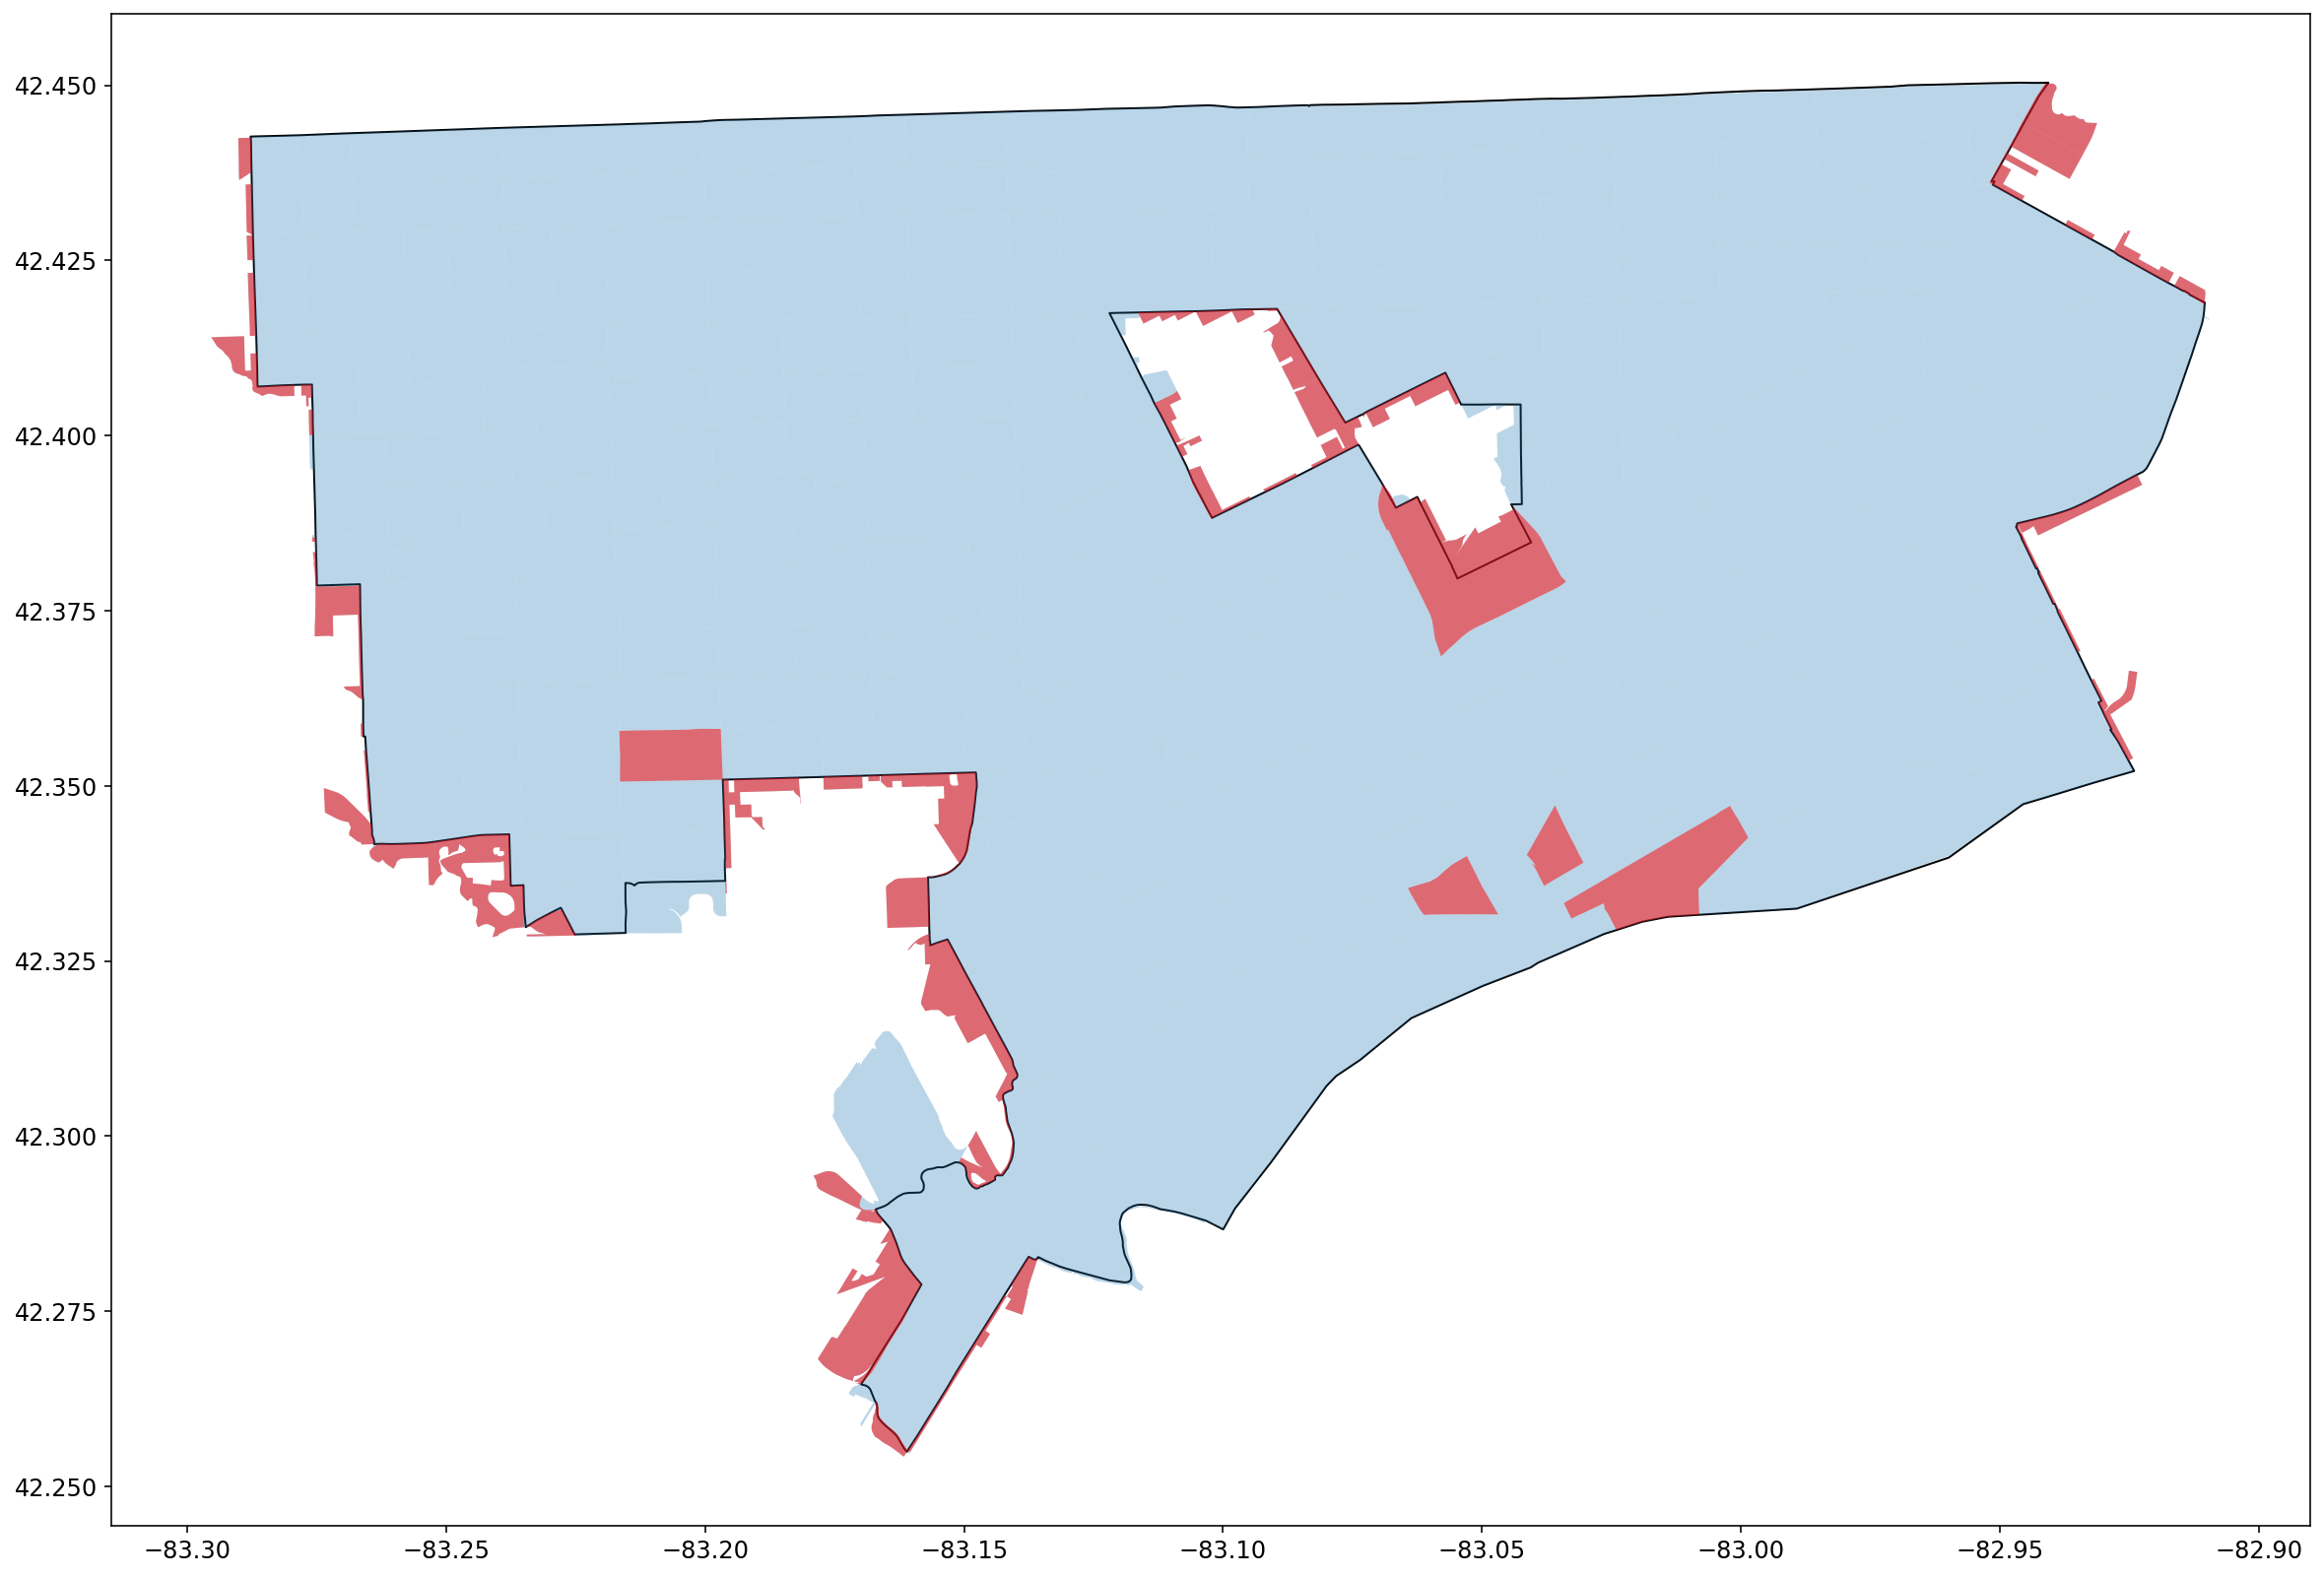

In [103]:
fig,ax=plt.subplots(1,1,figsize=(20,20))
detroit.plot(facecolor='none',ax=ax)
tracts.plot(ax=ax,alpha=0.3)
tracts.loc[(df.population/df.households).dropna().sort_values().head(40).index].plot(ax=ax,color='r',alpha=0.5)
# tracts.loc[lambda x: (x.latitude < 42.325)].plot(ax=ax,alpha=0.3)

<AxesSubplot:>

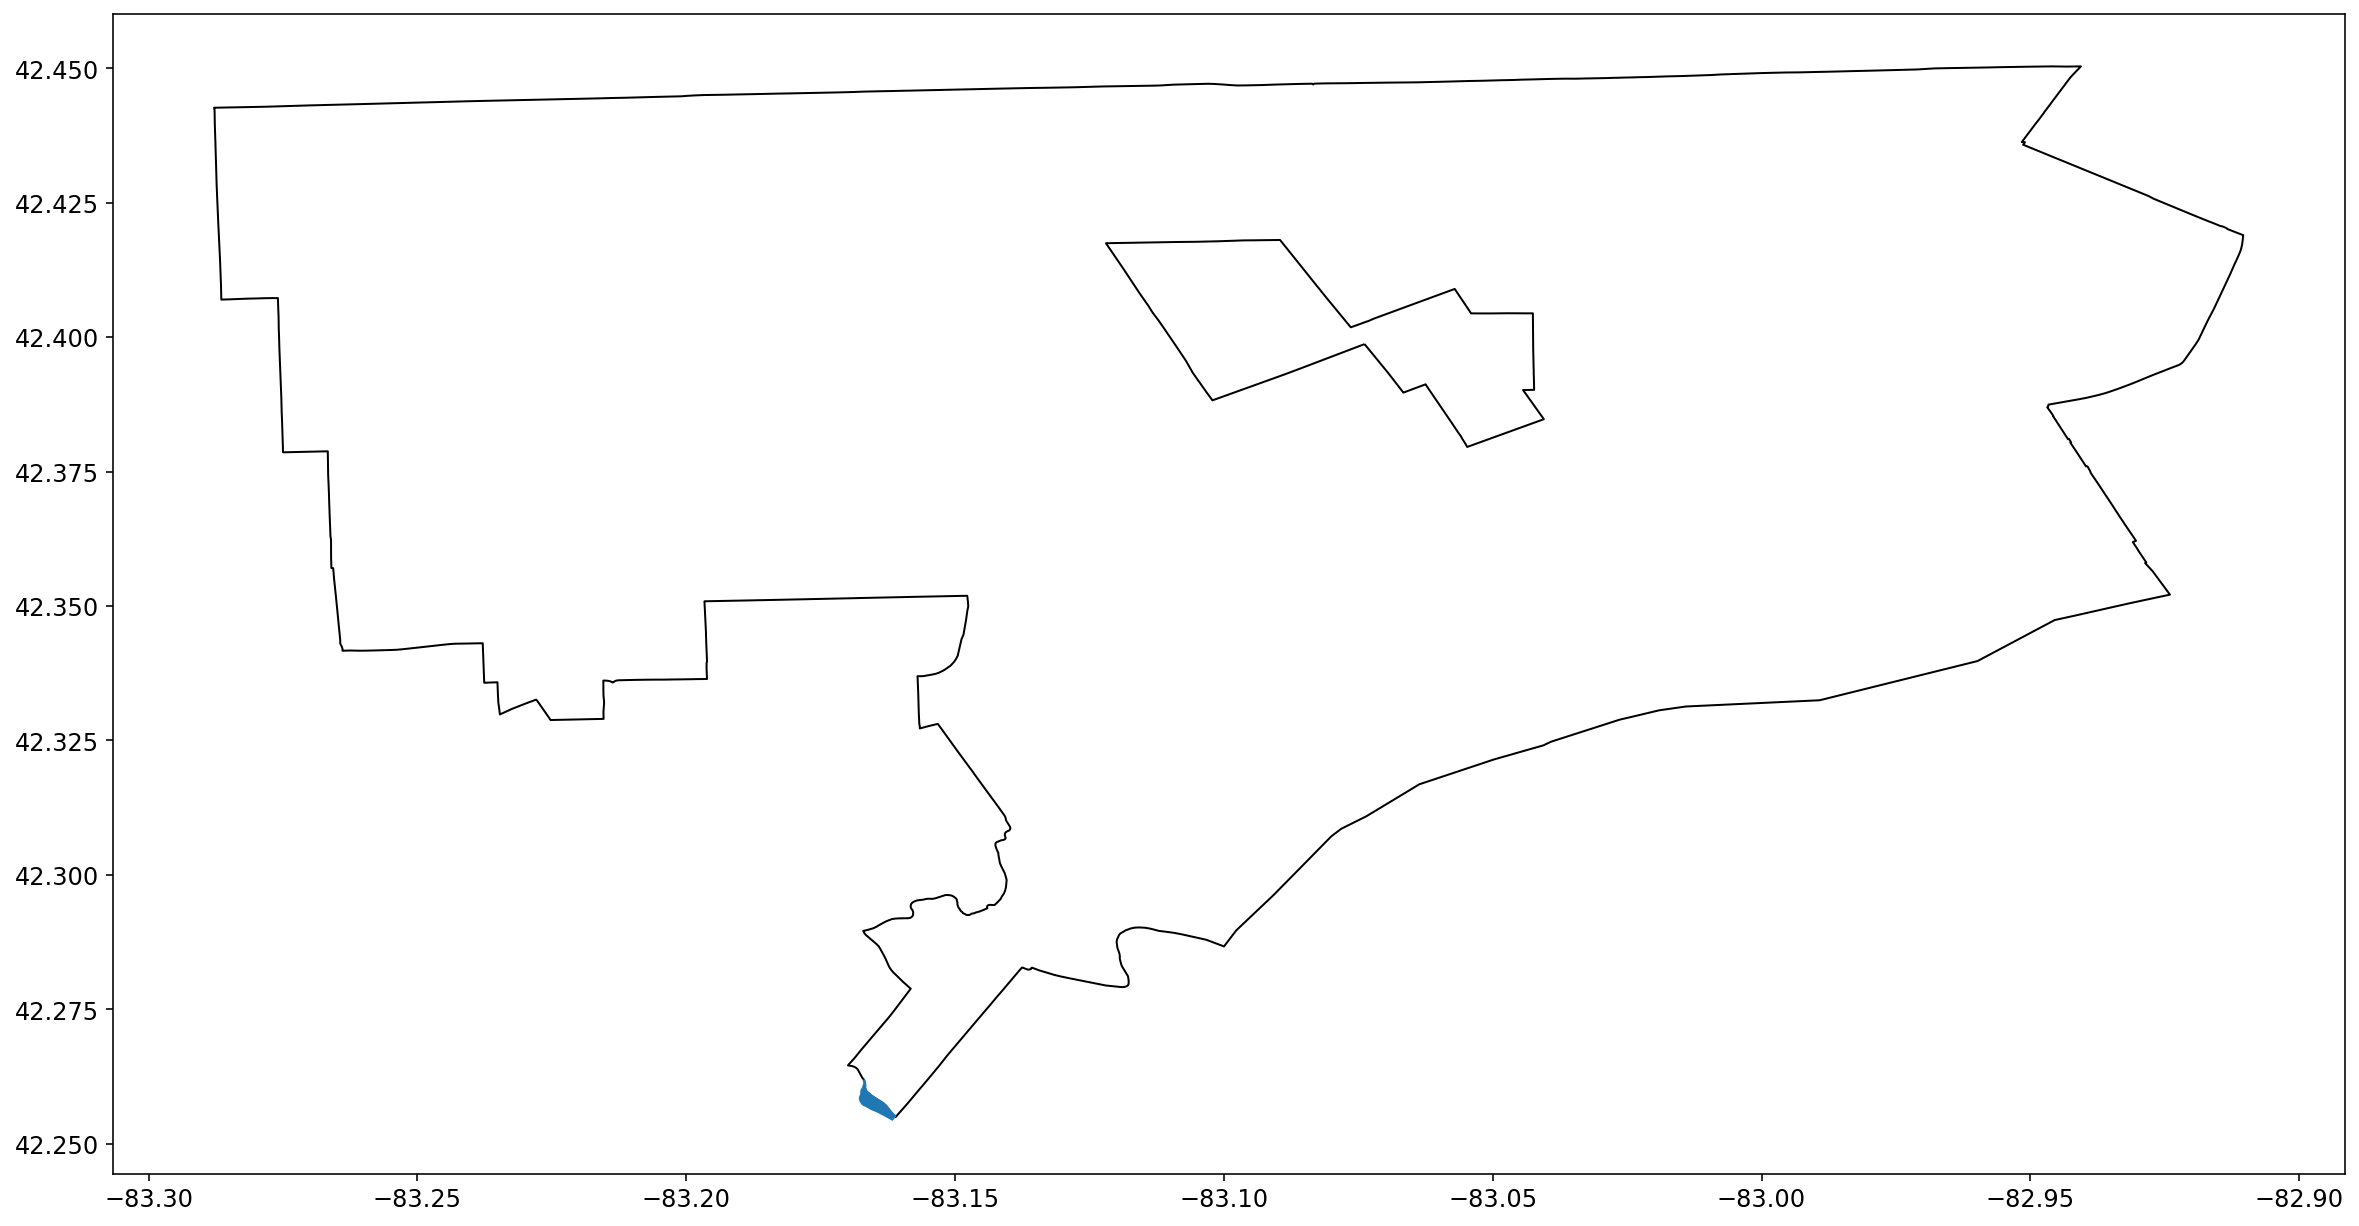

In [77]:
fig,ax=plt.subplots(1,1,figsize=(20,20))
detroit.plot(facecolor='none',ax=ax)
gpd.GeoDataFrame(tracts.loc[df.calls_per_capita.idxmax()].to_frame().T).plot(ax=ax)

In [38]:
df.loc[:,['population','violence_calls']].corr()**2

,population,violence_calls
population,1.000000,0.600627
violence_calls,0.600627,1.000000


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
tt.plot('population',ax=ax,legend=True)

In [27]:
pop = Population(decennial_census_year=2010,population_data_path='population').construct_feature('block')

Data not yet loaded, loading all data
Loaded 6778 rows
Data not yet cleansed, cleaning
clean data has 6778 rows
cleansed data validator: geo_id looks good
Generate index not run, or was run on the wrong grain. Creating index on block grain
9563 of 16341 blocks are unaccounted for


In [21]:
des = dmatrix(
    formula_like="""violence_calls + per_capita_income
    + per_household_income
    + per_capita_income*per_household_income
    + prop_married_families""",
    data=df.assign(prop_married_families=lambda x: x.married_families/x.households),
    return_type="dataframe",
)

In [140]:
des.head()

,Intercept,violence_calls,per_capita_income,per_household_income,per_capita_income:per_household_income
tract,,,,,
2.616350e+10,1.0,2257.0,3369.0,49015.0,165131535.0
2.616350e+10,1.0,2334.0,2834.0,61980.0,175651320.0
2.616350e+10,1.0,1948.0,1900.0,50345.0,95655500.0
2.616350e+10,1.0,1030.0,1052.0,34880.0,36693760.0
2.616350e+10,1.0,1450.0,1289.0,43058.0,55501762.0


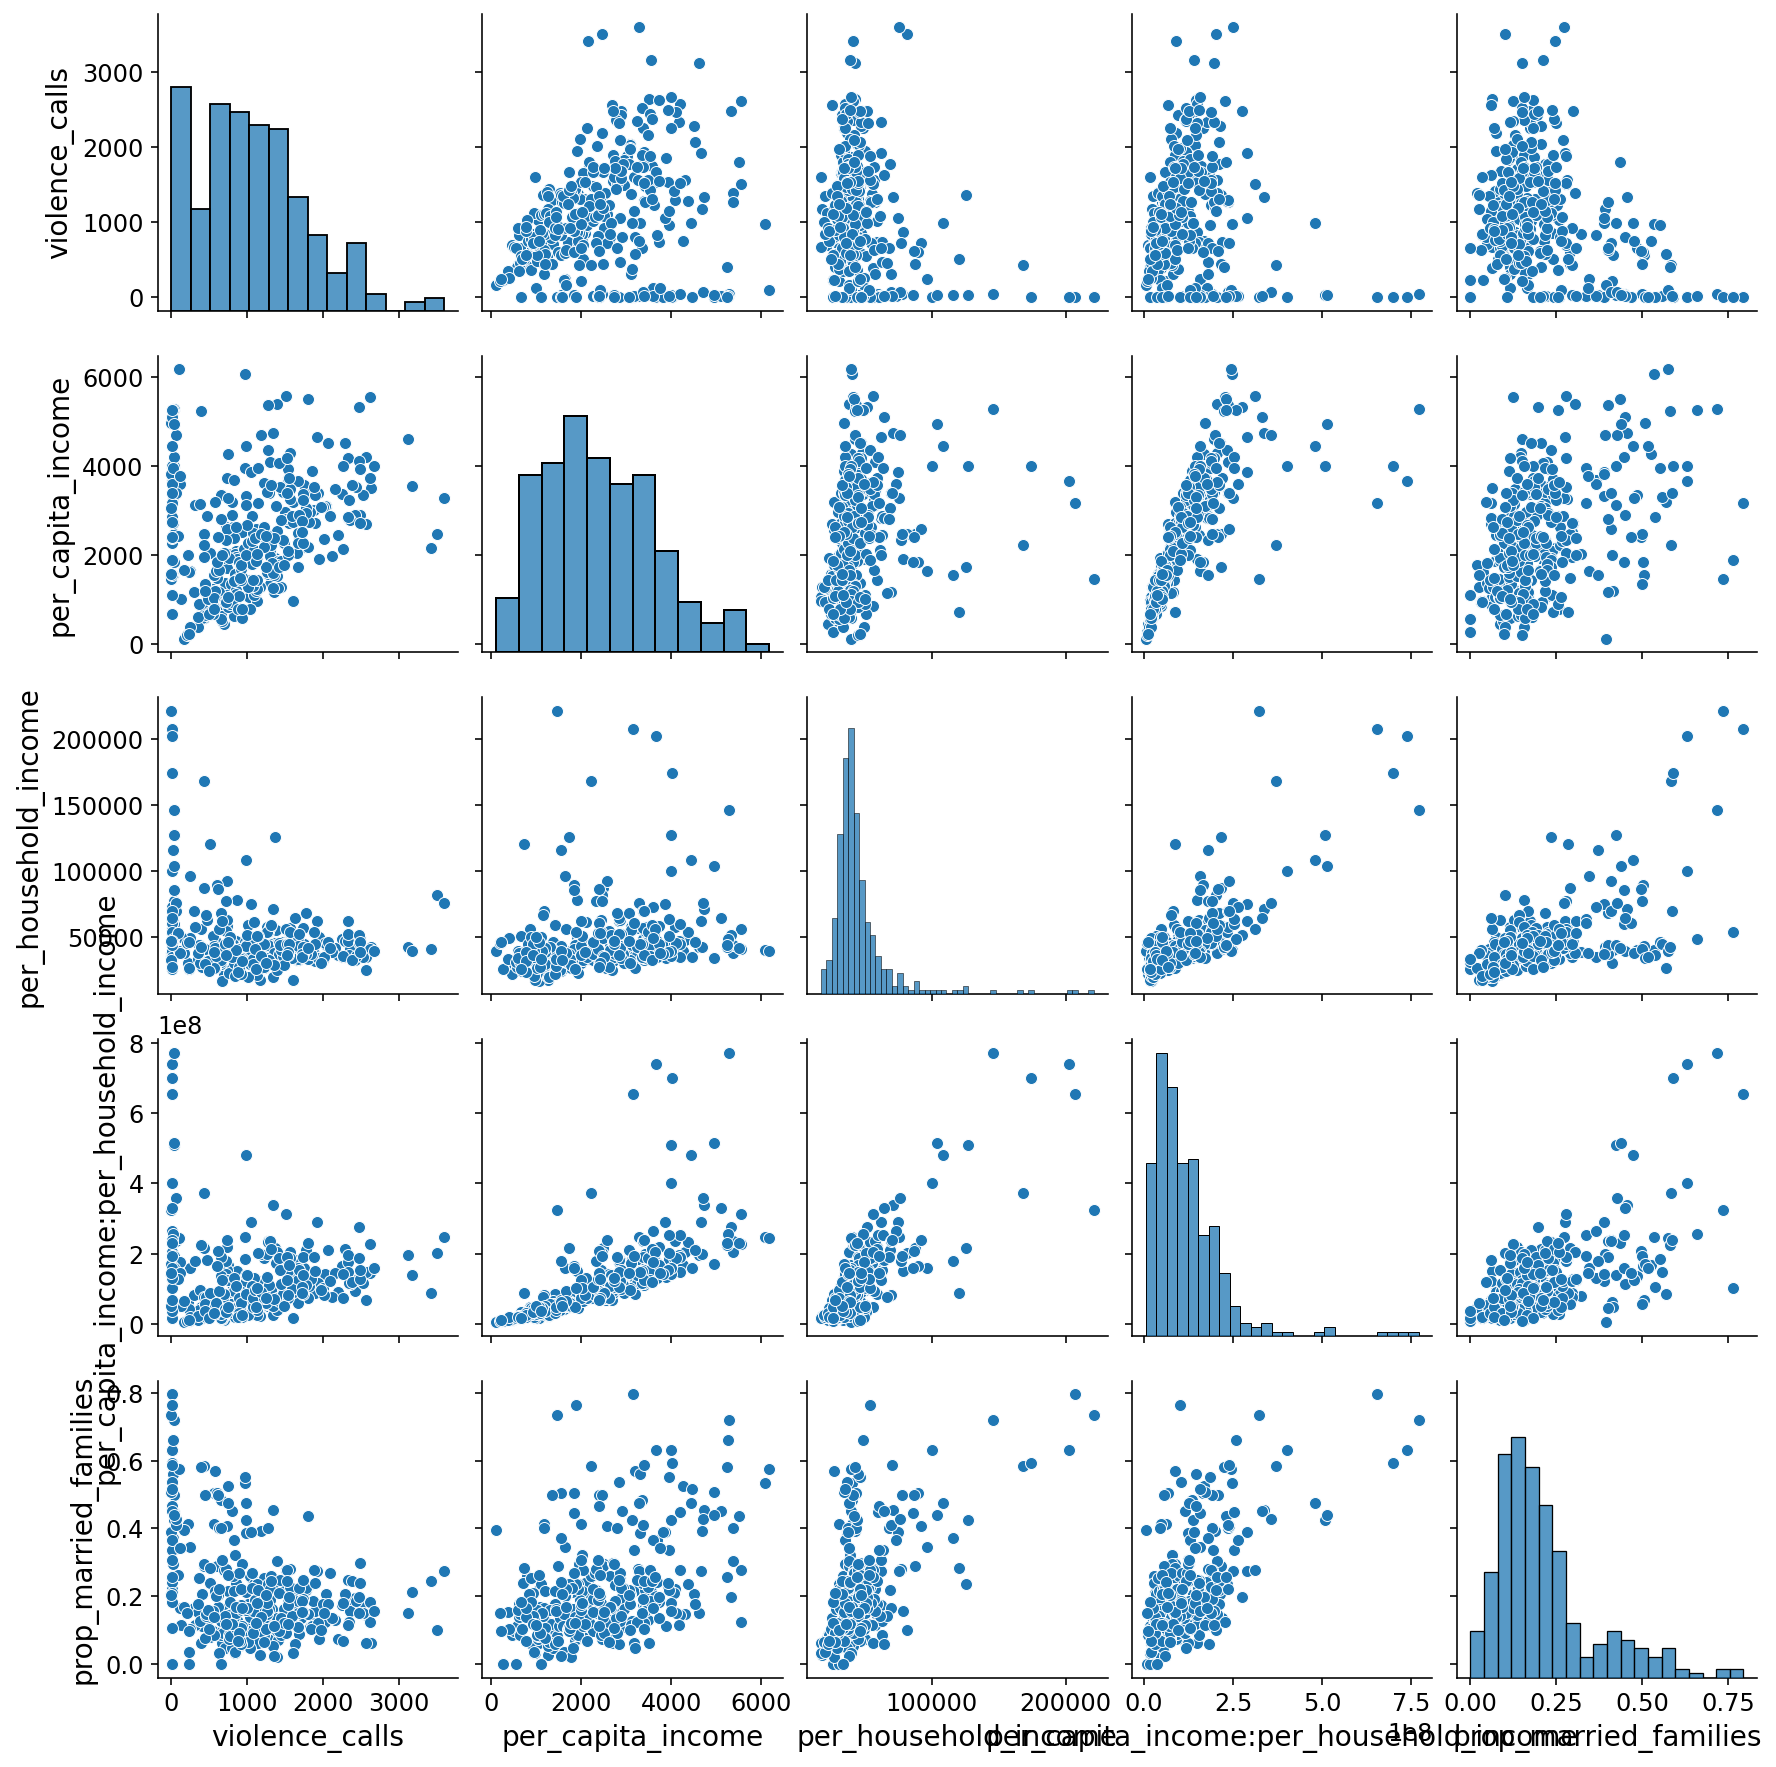

In [22]:
sns.pairplot(des.drop(columns=['Intercept']))

In [127]:
y, X = dmatrices(
    formula_like="""violence_calls ~ per_capita_income
    + per_household_income
    + per_capita_income*per_household_income""",
    data=df,
    return_type="dataframe",
)

In [118]:
mdl = sm.GLM(y,X,family=sm.families.Poisson())
res = mdl.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         violence_calls   No. Observations:                  339
Model:                            GLM   Df Residuals:                      335
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -78555.
Date:                Tue, 22 Feb 2022   Deviance:                   1.5431e+05
Time:                        14:47:31   Pearson chi2:                 1.35e+05
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  6.4788      0.011    609.751      0.000       6.458       6.500
per_capita_income                          0.0004   4.09e-06    103.293      0.000       0.000       0.000
per_household_income                    1.403e-06   2.45e-07      5.726      0.000    9.23e-07    1.88e-06
per_capita_income:per_household_income -5.399e-09   9.02e-11    -59.853      0.000   -5.58e-09   -5.22e-09
==========================================================================================================
"""

In [104]:
mdl.data.param_names

['Intercept',
 'per_capita_income',
 'per_household_income',
 'per_capita_income:per_household_income']

In [281]:
sm.graphics.plot_partregress("violence_calls","per_capita_income:per_household_income",["per_household_income","per_capita_income"],data=des,obs_labels=False)
plt.tight_layout()

NameError: name 'des' is not defined

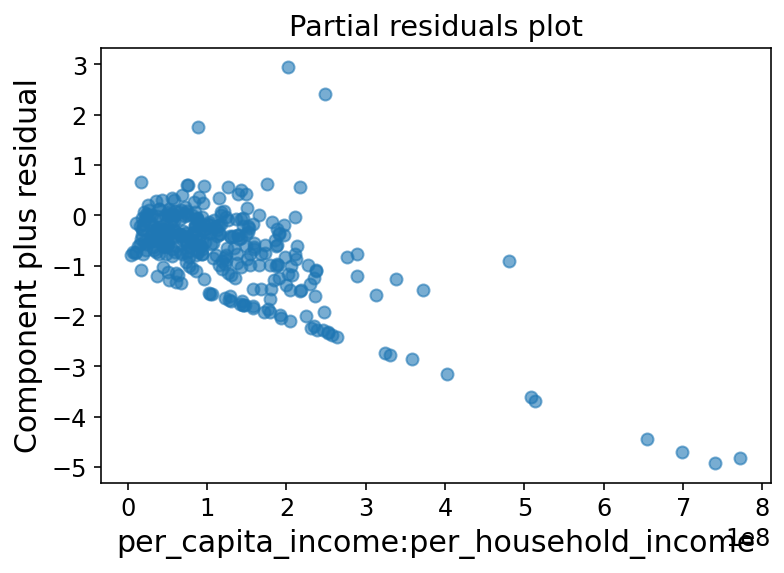

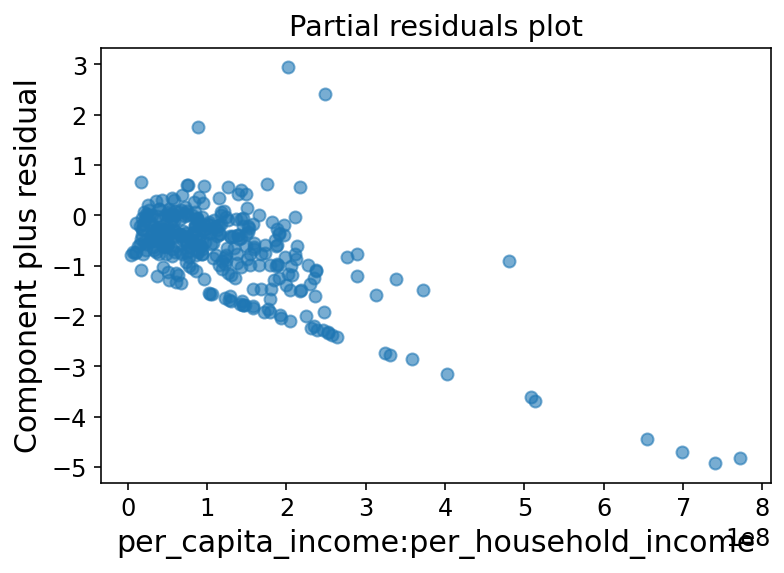

In [105]:
res.plot_partial_residuals('per_capita_income:per_household_income')
# res.plot_partial_residuals('per_household_income')

In [108]:
mdl = sm.OLS(feat_income.dropna().per_capita_income, feat_income.dropna().per_household_income)
res = mdl.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      per_capita_income   R-squared (uncentered):                   0.693
Model:                            OLS   Adj. R-squared (uncentered):              0.692
Method:                 Least Squares   F-statistic:                              764.3
Date:                Tue, 22 Feb 2022   Prob (F-statistic):                    7.10e-89
Time:                        13:57:49   Log-Likelihood:                         -2972.3
No. Observations:                 340   AIC:                                      5947.
Df Residuals:                     339   BIC:                                      5950.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
per_household_income     0.0429      0.002     27.645      0.000       0.040       0.046
==============================================================================
Omnibus:                       89.254   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              409.831
Skew:                          -1.026   Prob(JB):                     1.01e-89
Kurtosis:                       7.972   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
mdl = sm.OLS(y,X,)
res = mdl.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         violence_calls   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     33.03
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           7.99e-14
Time:                        13:45:03   Log-Likelihood:                -2685.9
No. Observations:                 339   AIC:                             5378.
Df Residuals:                     336   BIC:                             5389.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1002.2248     95.872     10.454      0.000     813.639    1190.810
per_capita_income        0.2013      0.030      6.662      0.000       0.142       0.261
per_household_income    -0.0089      0.001     -6.039      0.000      -0.012      -0.006
==============================================================================
Omnibus:                       19.104   Durbin-Watson:                   0.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.353
Skew:                           0.326   Prob(JB):                     2.11e-08
Kurtosis:                       4.441   Cond. No.                     1.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

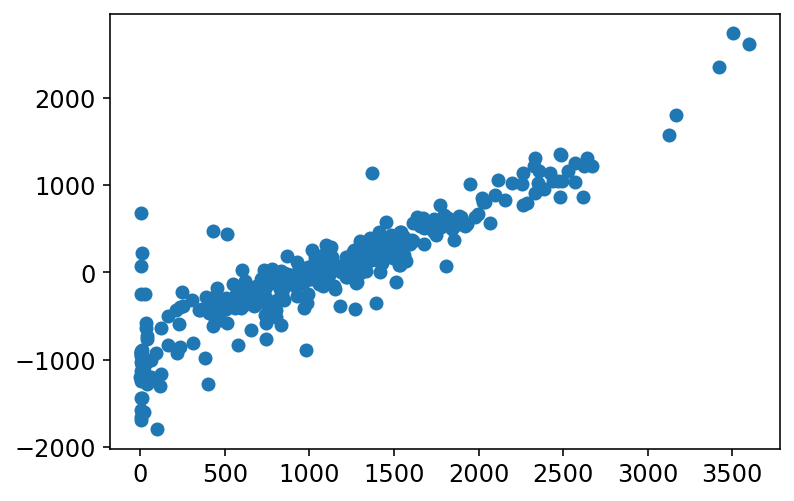

In [95]:
plt.scatter(y,res.resid)

In [40]:
raw = pd.read_csv('population/DECENNIALPL2010.P1_data_with_overlays_2022-02-06T092022.csv',usecols=['GEO_ID','P001001'],skiprows=[1])

In [59]:
rawish = raw.loc[raw.P001001.str.contains('\(')].assign(population=lambda x: x.P001001.str.split('(').apply(lambda x: x[0])).astype({'population':int})

In [62]:
rawish.population

89        69
94         8
107       27
108        0
171       37
        ... 
6178       4
6184       3
6377      75
10100    175
13562      8
Name: population, Length: 276, dtype: int64